In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

Read Dataset

In [5]:
#read dataset
df = pd.read_excel(r"Mall_Customers.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Dataset has 5 features ... Data Cleaning might still need to be done
The ID, Gender, Age, Income (Annual (thousand $)), Spending score... Credit Score??(On a scale of 1 - 100)

In [13]:
#display first 5 rows
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


<li>ID - Identifier - need to change to string(No aggregations to be performed)... Also not needed
<li>Gender - Male/Female
<li>Age, Income, SS - Discrete 


In [6]:
df.drop('CustomerID', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [7]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [8]:
df['Gender'].value_counts()

Gender
Female    112
Male       88
Name: count, dtype: int64

In [11]:
df.rename(columns={'Annual Income (k$)': 'Income'}, inplace=True)
df.rename(columns={'Spending Score (1-100)': 'Spending_Score'}, inplace=True)

In [12]:
df["Spending_Score"].value_counts()

Spending_Score
42    8
55    7
73    6
46    6
48    5
     ..
68    1
85    1
23    1
8     1
18    1
Name: count, Length: 84, dtype: int64

More females than males(not significant)

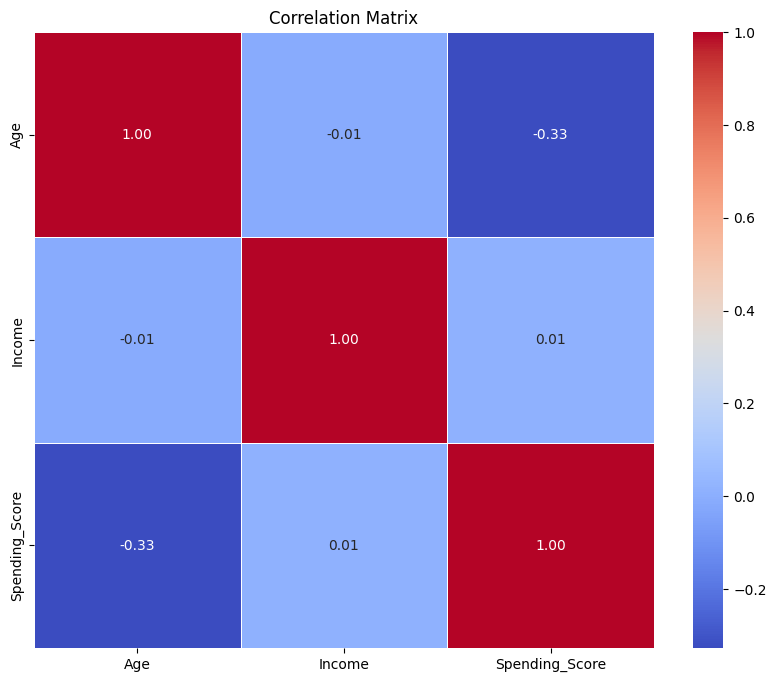

In [13]:
#correlation between Age, Income and Spending Score
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Income has almost no correlation with Age and the level of spending


Preprocesing Data

<ol>
<li>Perform One Hot Encoding on categorical columns</li></ol>

In [ ]:
#install scikit-learn if not already installed
#pip install scikit-learn

SyntaxError: invalid syntax (2077292135.py, line 2)

In [19]:
#perform One Hot Encoding on categorical column(Gender), dropping the first category to avoid multicollinearity

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(df[['Gender']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Gender']))
df_encoded = pd.concat([df.drop('Gender', axis=1), encoded_df], axis=1)
df_encoded.head()

,Age,Income,Spending_Score,Gender_Male
0,19,15,39,1.0
1,21,15,81,1.0
2,20,16,6,0.0
3,23,16,77,0.0
4,31,17,40,0.0


In [15]:
encoder = OrdinalEncoder()
encoded = encoder.fit_transform(df[["Spending_Score"]])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Spending_Score']))
df_encoded = pd.concat([df.drop('Spending_Score', axis=1), encoded_df], axis=1)
df_encoded.head()


,Gender,Age,Income,Spending_Score
0,Male,19,15,30.0
1,Male,21,15,67.0
2,Female,20,16,4.0
3,Female,23,16,64.0
4,Female,31,17,31.0


### KMeans Clustering

This cell applies KMeans clustering to the preprocessed dataset (`data_encoded`). The KMeans algorithm is fitted with 3 clusters, and the resulting cluster labels are added as a new column (`cluster`) to the dataframe. The updated dataframe with cluster assignments is displayed.

In [20]:
X = df_encoded

# Fit KMeans with 3 clusters (defined by Gbenga)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# Add cluster labels to the dataframe
df_encoded['cluster'] = clusters

df_encoded.head()

,Age,Income,Spending_Score,Gender_Male,cluster
0,19,15,39,1.0,2
1,21,15,81,1.0,2
2,20,16,6,0.0,0
3,23,16,77,0.0,2
4,31,17,40,0.0,2


### Elbow Method for Optimal Number of Clusters

This cell calculates and visualizes the inertia (sum of squared distances to the nearest cluster center) for different values of `k` (number of clusters) using the KMeans algorithm. The inertia values are plotted against the number of clusters to help identify the "elbow point," which suggests the optimal number of clusters for KMeans clustering on the dataset.

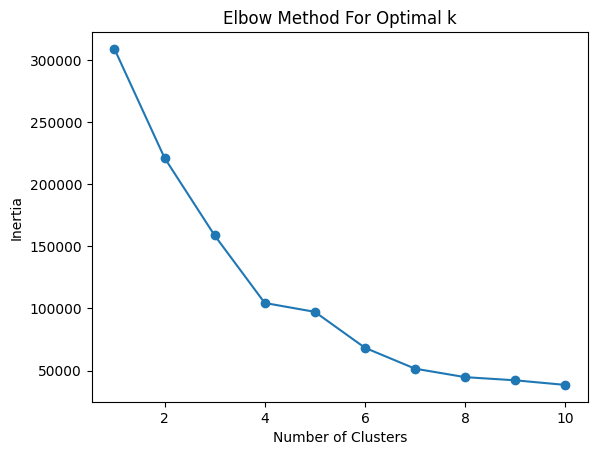

In [21]:
inertia = []
cluster_range = range(1, 11)
for k in cluster_range:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X)
  inertia.append(kmeans.inertia_)

plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

### Feature Selection for Clustering

To properly visualize the clustering, selects a subset of features (`cholesterol`, `bmi`, and `blood_pressure`) from the preprocessed dataset (`data_encoded`) to perform clustering. It fits the KMeans algorithm with 3 clusters to the selected features and assigns the resulting cluster labels to a new column (`cluster`).

In [22]:
# Subset the dataframe to include only relevant features for clustering
X_sub = df_encoded[['Age', 'Income', 'Spending_Score']]

# Fit KMeans with 3 clusters (you can change n_clusters as needed)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# Add cluster labels to the dataframe
X_sub['cluster'] = clusters

X_sub.head()

C:\Users\vicky\AppData\Local\Temp\ipykernel_30536\216901158.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_sub['cluster'] = clusters


,Age,Income,Spending_Score,cluster
0,19,15,39,2
1,21,15,81,2
2,20,16,6,0
3,23,16,77,2
4,31,17,40,2


### Visualization of Subset Dataset Clusters

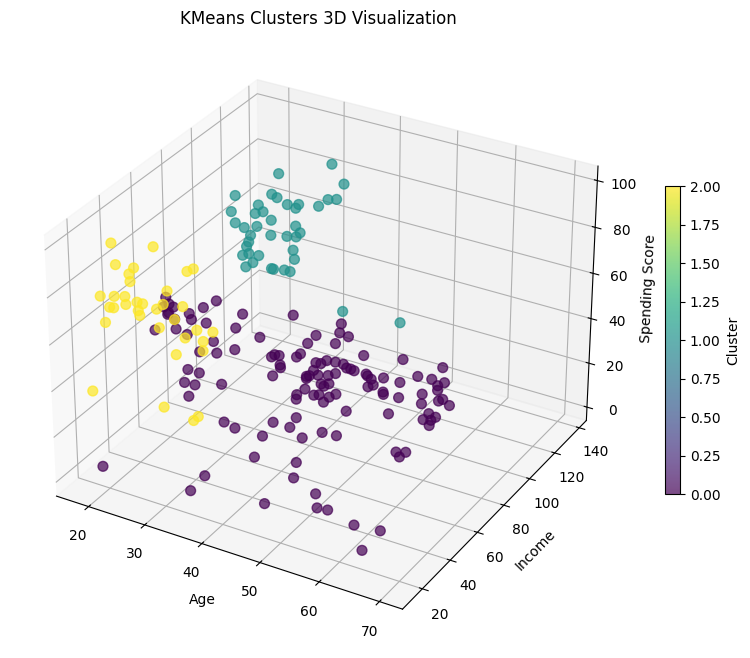

In [23]:
# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_sub['Age'], X_sub['Income'], X_sub['Spending_Score'], 
                    c=X_sub['cluster'], cmap='viridis', alpha=0.7, s=50)

ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Spending Score')
ax.set_title('KMeans Clusters 3D Visualization')

# Add colorbar legend
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=20, label='Cluster')

plt.show()